# Preparation

## Import

In [1]:
# Imports
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pathlib
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow import keras
from tensorflow.keras import layers
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


**AUTOTUNE**: 

* **map**: transform the dataset according to a function, in this case converts the images to float
* **cache**: keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
* **prefetch**: for optimization porpuses 

In [2]:
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

In [3]:
def get_dataset(training_dir, test_dir, batch_size = 32, greyscale = True):

    color = 'grayscale'
    if(not greyscale):
        color = 'rgb'

    train_ds = tf.keras.utils.image_dataset_from_directory(
        training_dir,
        seed=420,
        image_size=(img_height, img_width),
        batch_size= batch_size,
        validation_split=0.2,
        subset="training",
        color_mode=color,
    )

    val_ds = tf.keras.utils.image_dataset_from_directory(
        training_dir,
        seed=420,
        image_size=(img_height, img_width),
        batch_size= batch_size,
        validation_split=0.2,
        subset="validation",
        color_mode= color,
    )

    test_ds = tf.keras.utils.image_dataset_from_directory(
        test_dir,
        seed=420,
        image_size=(img_height, img_width),
        batch_size= batch_size,
        color_mode= color,

    )


    AUTOTUNE = tf.data.experimental.AUTOTUNE

    ds_train = train_ds.map(convert_to_float).cache().prefetch(buffer_size=AUTOTUNE)
    ds_valid = val_ds.map(convert_to_float).cache().prefetch(buffer_size=AUTOTUNE)
    ds_test = test_ds.map(convert_to_float).cache().prefetch(buffer_size=AUTOTUNE)

   
    class_names = train_ds.class_names

    

    return (ds_train, ds_valid, ds_test, class_names)



In [4]:
def print_16_imgs(dataset):
    imgs = np.concatenate([x for x, y in dataset], axis=0)
    labels = np.concatenate([y for x, y in dataset], axis=0)

    plt.figure(figsize=(10,10))
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(imgs[i].astype('uint8'), cmap=plt.cm.binary)
        plt.grid(False)
        plt.title(class_names[labels[i]][10:-1])



In [20]:
def create_model():

    data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal", input_shape=(img_height, img_width, img_depth)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
    )


    model = keras.Sequential([

        #data_augmentation,
        layers.Rescaling(1./255), # only with rgb

        layers.Conv2D(32, 3, padding='same', activation='relu' ),
        layers.MaxPooling2D(),

        layers.Conv2D(64, 3, padding='same', activation='relu'), # relu for hidden layers
        layers.MaxPooling2D(),

        #layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(16),
        #layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax') # softmax for probablities 


    ])

    model.compile(
        optimizer='adam',
        loss= tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy'],
    )

    model.build((None, img_width, img_height, img_depth))


    model.summary()
    return model



## Parameters

In [6]:
img_height = 224
img_width = 224
img_depth = 3 # 1 if greyscale 3 if rgb
n_epochs = 10

## Create training and validation set

### Load directories 

In [7]:
# drive 
#training_dir = pathlib.Path('/datasets/animali/animals_dataset_the_ostriches/animals_dataset/training')
# test_dir = pathlib.Path('/datasets/animali/animals_dataset_the_ostriches/animals_dataset/validation2/gallery/')

#local
training_dir = pathlib.Path('/work/dataset/training')
query_dir = pathlib.Path('/work/dataset/validation/query')
gallery_dir = pathlib.Path('/work/dataset/validation/gallery')



### Create dataset object 

In [8]:
train,val,test, class_names = get_dataset(training_dir, gallery_dir , greyscale=False)



Found 2174 files belonging to 10 classes.
Using 1740 files for training.
Found 2174 files belonging to 10 classes.
Using 434 files for validation.
Found 463 files belonging to 6 classes.


## Check data distribution

In [9]:
y = np.concatenate([y for x, y in train_ds], axis=0)

unique, counts = np.unique(y, return_counts=True)

plt.bar(unique, counts)
plt.xticks(unique)
plt.title("class distribution")
plt.xlabel("class")
plt.ylabel("count")
plt.show()

NameError: name 'train_ds' is not defined

# Model

In [21]:
model = create_model()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 200704)           

In [22]:


history = model.fit(
    train.take(100),
    validation_data=val,
    epochs= 1,
)

55/55 [==============================] - 145s 3s/step - loss: 2.7035 - accuracy: 0.1718 - val_loss: 2.0405 - val_accuracy: 0.2558


# Evaluation

potrebbe essere migliorato ma è un buon  punto di partenza

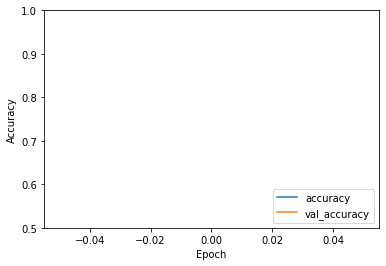

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

# Test and error analysis

### confusion matrix 

In [ ]:
model.evaluate(test)


15/15 [==============================] - 13s 787ms/step - loss: 5.1983 - accuracy: 0.0842


[5.198348522186279, 0.08423326164484024]

In [23]:
predictions = model.predict(test)  # Vector of probabilities


In [27]:
pred_labels = np.argmax(predictions, axis = 1)
print(sorted(predictions[0], reverse=True))
pred_labels[0]



[0.14876945, 0.1478194, 0.119348615, 0.115877435, 0.11012418, 0.1021127, 0.09581499, 0.061576147, 0.0551919, 0.043365207]


463.0

In [ ]:

predictions = model.predict(test)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability
test_labels = np.concatenate([y for x, y in ds_test], axis=0)
class_names = train_ds.class_names

CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sns.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

NameError: name 'model' is not defined

In [ ]:
def display_examples(class_names, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()



def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    """
        Print 25 examples of mislabeled images by the classifier, e.g when test_labels != pred_labels
    """
    test_images = np.concatenate([x for x, y in ds_test], axis=0)

    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    title = "Some examples of mislabeled images by the classifier:"
    display_examples(class_names,  mislabeled_images, mislabeled_labels)

print_mislabeled_images(class_names, ds_test, test_labels, pred_labels)



NameError: name 'test_labels' is not defined

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=93aceac2-8452-469e-8b02-c16d0438aa9c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>